Prediccion de generacion de energia con Red neuronal tipo MLP

In [3]:
#Importacion de librerias
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [4]:
# Cargar el dataset
datset_path = r"C:\Users\jhean\OneDrive\Documentos\Tareas\Inteligencia artificial\1erParcial\Dataset\EIA923_Cleaned_2020_2024.xlsx"
df = pd.read_excel(datset_path)
df.head()

,Plant_ID,Plant_Name,State,Fuel_Consumed_MMBtu,Net_Generation_MWh,Year
0,1,Sand Point,AK,3043,347.0,2020
1,2,Bankhead Dam,AL,1220102,139170.0,2020
2,3,Barry,AL,1243854,2633517.0,2020
3,3,Barry,AL,53006762,5084350.0,2020
4,3,Barry,AL,26188716,2625834.5,2020


In [ ]:

# One-hot encoding para 'State'
X = df[["Fuel_Consumed_MMBtu", "Year", "State"]]
X = pd.get_dummies(X, columns=["State"], drop_first=True)
y = df["Net_Generation_MWh"]

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar los datos
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Convertir a tensores
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)



In [7]:
class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super(MLPRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),   # capa oculta 1
            nn.ReLU(),
            nn.Linear(64, 32),          # capa oculta 2
            nn.ReLU(),
            nn.Linear(32, 1)            # capa de salida
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
input_dim = X_train_tensor.shape[1]  # Cantidad de columnas de entrada
model = MLPRegressor(input_dim)


In [9]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

epochs = 500
loss_history = []


In [10]:
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if epoch % 50 == 0 or epoch == epochs - 1:
        print(f"Época {epoch}: Pérdida = {loss.item():.2f}")


Época 0: Pérdida = 1.01
Época 50: Pérdida = 0.12
Época 100: Pérdida = 0.09
Época 150: Pérdida = 0.09
Época 200: Pérdida = 0.09
Época 250: Pérdida = 0.09
Época 300: Pérdida = 0.09
Época 350: Pérdida = 0.09
Época 400: Pérdida = 0.09
Época 450: Pérdida = 0.09
Época 499: Pérdida = 0.09


c:\Users\jhean\OneDrive\Documentos\Tareas\Inteligencia artificial\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


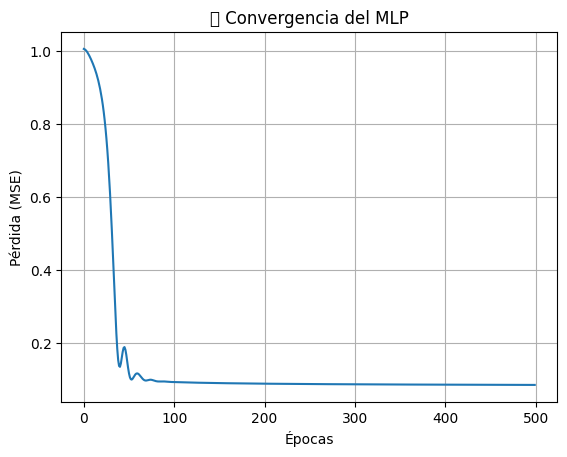

In [11]:
plt.plot(loss_history)
plt.xlabel("Épocas")
plt.ylabel("Pérdida (MSE)")
plt.title("📉 Convergencia del MLP")
plt.grid(True)
plt.show()


In [12]:
# Predicción
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_tensor).numpy()

# Invertimos el escalado
y_pred_test_mlp = scaler_y.inverse_transform(y_pred_scaled)
y_true_test = scaler_y.inverse_transform(y_test_tensor.numpy())


In [13]:
# Cambiar a modo evaluación
model.eval()

# Desactivamos el cálculo del gradiente (más eficiente)
with torch.no_grad():
    y_pred_test_mlp = model(X_test_tensor).numpy()

# Convertimos y_test_tensor a array para compararlo
y_true_test = y_test_tensor.numpy()

# Calcular métricas
mse_mlp = mean_squared_error(y_true_test, y_pred_test_mlp)
r2_mlp = r2_score(y_true_test, y_pred_test_mlp)

print(f"📊 MSE del MLP en el conjunto de prueba: {mse_mlp:.2f}")
print(f"📈 R² Score del MLP en el conjunto de prueba: {r2_mlp:.4f}")


📊 MSE del MLP en el conjunto de prueba: 0.09
📈 R² Score del MLP en el conjunto de prueba: 0.9103


c:\Users\jhean\OneDrive\Documentos\Tareas\Inteligencia artificial\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


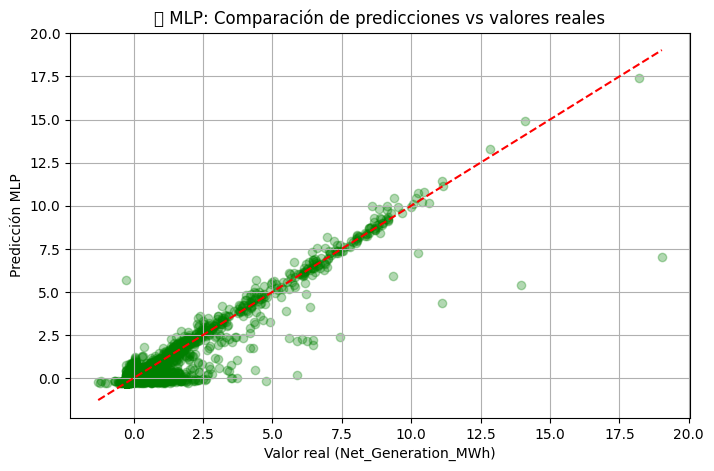

In [14]:
plt.figure(figsize=(8, 5))
plt.scatter(y_true_test, y_pred_test_mlp, alpha=0.3, color='green')
plt.plot([y_true_test.min(), y_true_test.max()],
         [y_true_test.min(), y_true_test.max()], color='red', linestyle='--')
plt.xlabel("Valor real (Net_Generation_MWh)")
plt.ylabel("Predicción MLP")
plt.title("🎯 MLP: Comparación de predicciones vs valores reales")
plt.grid(True)
plt.show()
